### Upwelled tracer

In this notebook we compare Tr mass and HCW in all 4 runs and for all tracers. Then we find the tracer and water upwelling flux ($\Phi$, $\Phi_{Tr}$) and compare it to scaling estimates from Ramos-Musalem and Allen 2019 and Howatt and Allen 2013, respectively.

* HCW all calculated with lin tracer, but shouldn't it be the same for all tracers ideally? Ideally, I think so, but some profiles will be more diffusive (if they concave) and thus, will find less upwelled water. By sticking to the linear profile we guaratee that we are counting tracer mass only on the same pool for water.

* TrMass calculated using lin tracer to find cells with upwelled water and concetration from the tracer we are studying.

CAREFUL: UNITS ARE ALL WEIRD FOR OXY, DIC, ALK!! To go from molality to molarity multiply , for example (sw = seawater)

I have converted from umol/kg to uM in the calculation for HCW, TrMass, etc.

In [28]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import xarray as xr
import matplotlib.gridspec as gspec

In [29]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [30]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [31]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

In [32]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'


state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [33]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

### 01 - Initial profiles

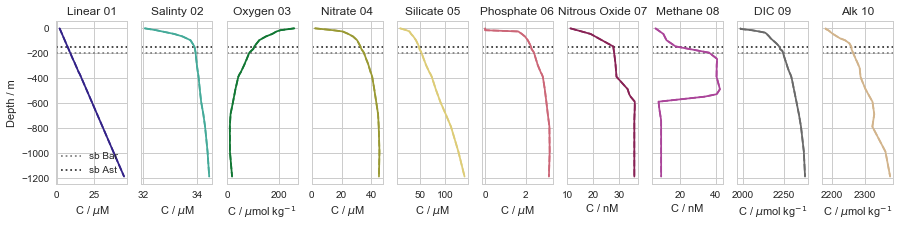

In [34]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

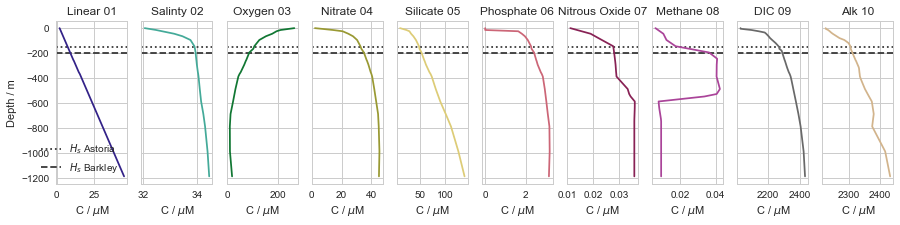

In [35]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-150, linestyle=':', color='0.2', label='$H_s$ Astoria')
    ax[ii].axhline(-200, linestyle='--', color='0.2', label='$H_s$ Barkley')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        with Dataset(pfile, 'r') as nbl:
        
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(1E-3*tr_profile, Z, color=col,linestyle=style)
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                ax[ii].plot(density*tr_profile/1000, Z, color=col,linestyle=style)
                ax[ii].set_xlabel(r'C / $\mu$M')
            
            
            else:
                ax[ii].set_xlabel(r'C / $\mu$M')
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax[ii].plot(tr_profile, Z, color=col,linestyle=style)

        ax[ii].set_title(lab)
        
        
ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

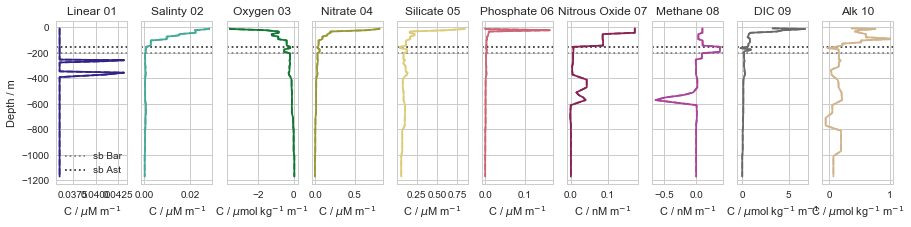

In [36]:
dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))
Tr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            dTr_Bar[ii] = dTrdz[sb_Bar+1]/dTrdz[sb_Bar-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            Tr_Bar[ii] = tr_profile[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM m$^{-1}$')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$ m$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M m$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Get initial concentration at shelf break

In [37]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]
                
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                tr_profile = density*nbl.variables[trac][0,:,10,180]/1000
                density = call_rho(0,state,slice(0,104),180,20)
                sb_array[ii] = tr_profile[sb_ind]

            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                sb_array[ii] = tr_profile[sb_ind]

### 02 - HCW



Canyon runs, using linear tracer

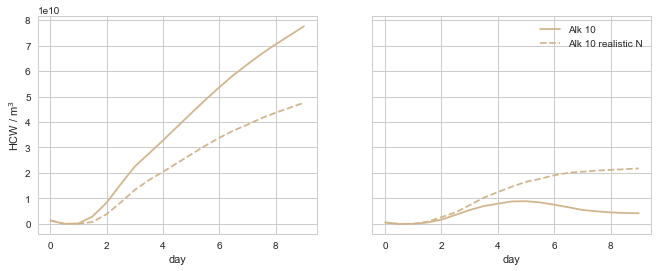

In [38]:
fig, ax = plt.subplots(1,2,figsize=(11,4), sharey=True)

f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %'Tr01')
df_Ast = pd.read_csv(f_Ast)
HCW_Ast = df_Ast['HCW']
f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %'Tr01')
df_Ast3 = pd.read_csv(f_Ast3)
HCW_Ast3 = df_Ast3['HCW']

ax[0].plot(np.arange(19)/2, HCW_Ast, color=col, label=lab)
ax[0].plot(np.arange(19)/2, HCW_Ast3,'--', color=col, label=lab)

f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %'Tr01')
df_Bar = pd.read_csv(f_Bar)
HCW_Bar = df_Bar['HCW']
f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %'Tr01')
df_Bar3 = pd.read_csv(f_Bar3)
HCW_Bar3 = df_Bar3['HCW']

ax[1].plot(np.arange(19)/2, HCW_Bar, color=col, label=lab)
ax[1].plot(np.arange(19)/2, HCW_Bar3,'--', color=col, label=lab +' realistic N')

ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')

ax[1].legend(bbox_to_anchor=(1,1))

### 03. Upwelled Tracer - Astoria bathymetry

**Canyon runs, Astorias**

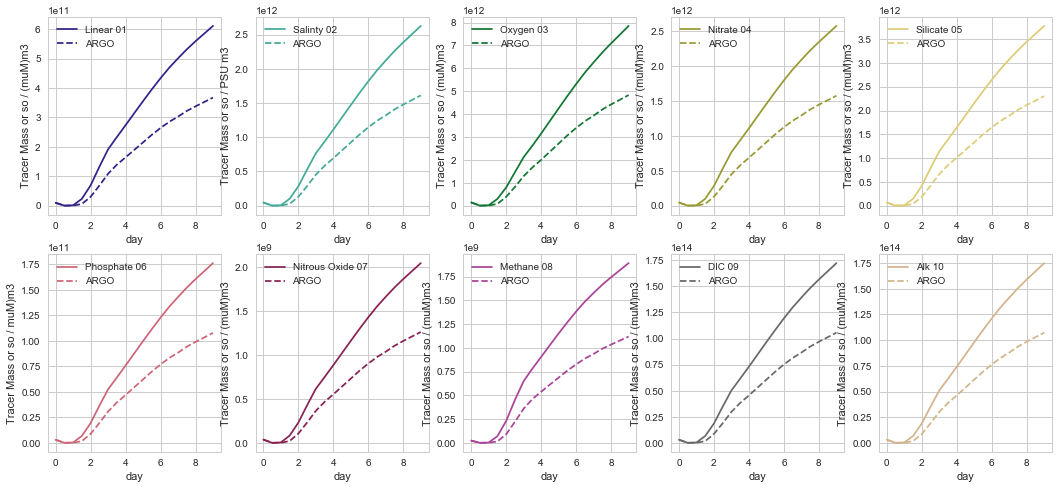

In [39]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



**No canyon**

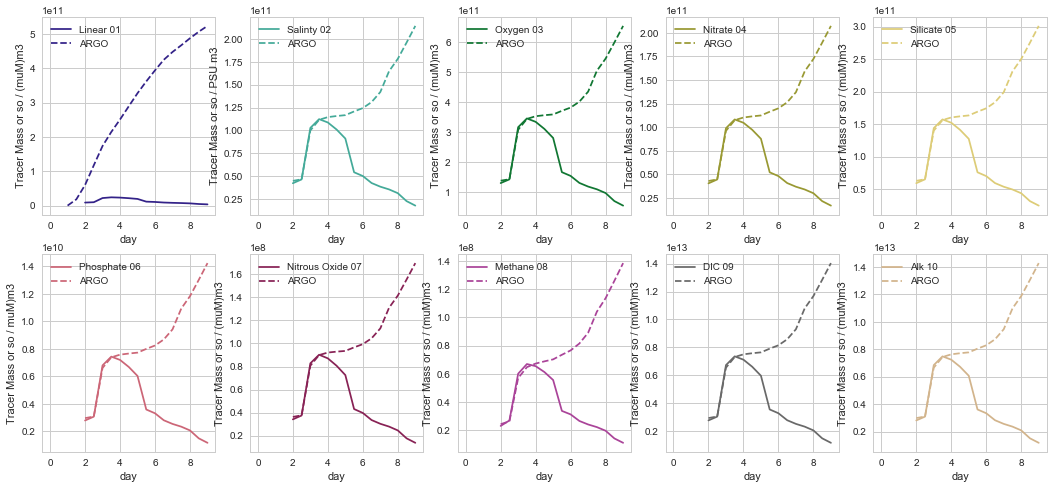

In [40]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



**Canyon effect** (Can - no Can runs)

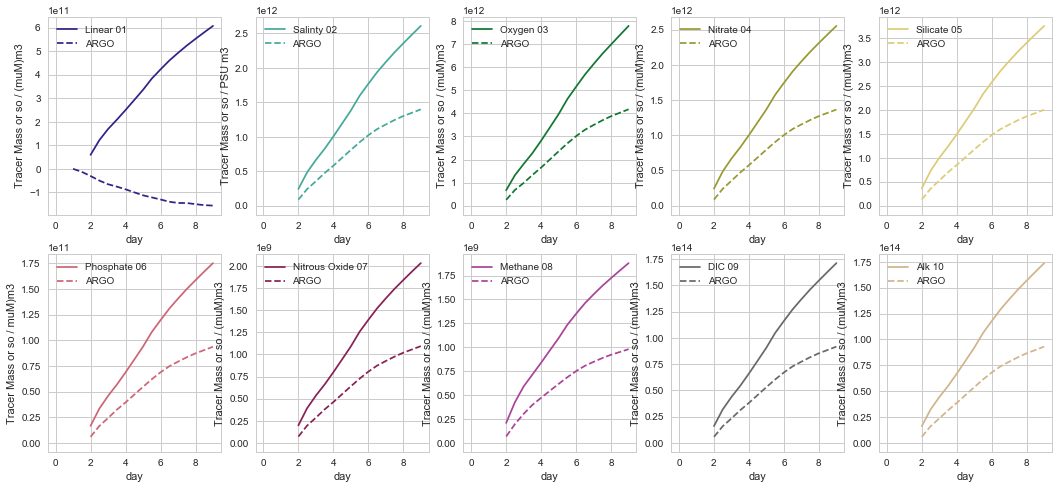

In [41]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_AstNoC = df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']

    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='ARGO')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



#### 3.1 Tracer flux vs upwelling flux $\times$ C_sb (all from model output)

Linear 01, error -4.168 percent 
Linear 01 ARGO, error -3.614 percent 
Salinty 02, error 0.179 percent 
Salinty 02 ARGO, error 0.134 percent 
Oxygen 03, error 1.250 percent 
Oxygen 03 ARGO, error 1.766 percent 
Nitrate 04, error -0.220 percent 
Nitrate 04 ARGO, error -0.336 percent 
Silicate 05, error -0.070 percent 
Silicate 05 ARGO, error -0.126 percent 
Phosphate 06, error 0.074 percent 
Phosphate 06 ARGO, error 0.030 percent 
Nitrous Oxide 07, error 6.516 percent 
Nitrous Oxide 07 ARGO, error 5.663 percent 
Methane 08, error -20.224 percent 
Methane 08 ARGO, error -17.790 percent 
DIC 09, error 2.382 percent 
DIC 09 ARGO, error 2.340 percent 
Alk 10, error 2.318 percent 
Alk 10 ARGO, error 2.263 percent 
103878.21882047845
62858.30456360651


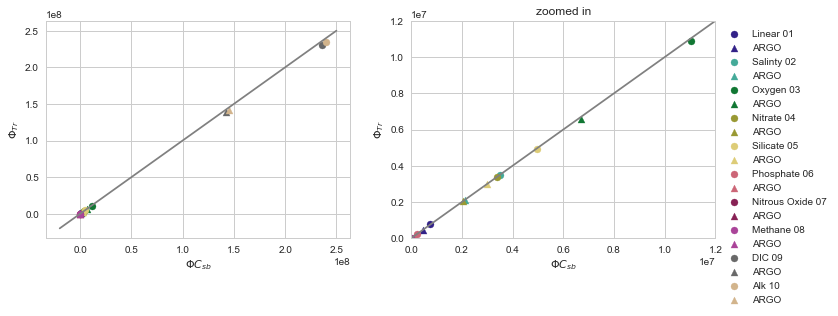

In [42]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,2.5E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    HCW = df['HCW'][:]
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    HCWARGO = dfARGO['HCW'][:]
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = 1E-3*df['TrMassHCW'][:]
        TrMassARGO = 1E-3*dfARGO['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]
        TrMassARGO = dfARGO['TrMassHCW'][:]
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    
    error = 100*(Phi*C-PhiTr)/PhiTr
    errorARGO = 100*(PhiARGO*C-PhiTrARGO)/PhiTrARGO
    
    ax.scatter(Phi*C, PhiTr, c=col, label=lab)
    ax2.scatter(Phi*C, PhiTr, c=col, label=lab)
     
    ax.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label=lab)
    ax2.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label='ARGO')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s ARGO, error %1.3f percent ' %(lab, errorARGO))
    
ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_ylabel(r'$\Phi_{Tr}$')
ax2.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlim(0,0.12E8)
ax2.set_ylim(0,0.12E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)
print(PhiARGO)


It is reasonable to scale tracer flux $\Phi_{Tr}$ as upwelling flux $\Phi C_{sb}$ within 2% except for Linear (10%) and Methane ($\sim$25%) and nitrous oxide ($\sim$7%), salinity 10.25%

### 4. Upwelled tracer - Barkley bathymetries

**Canyon runs**

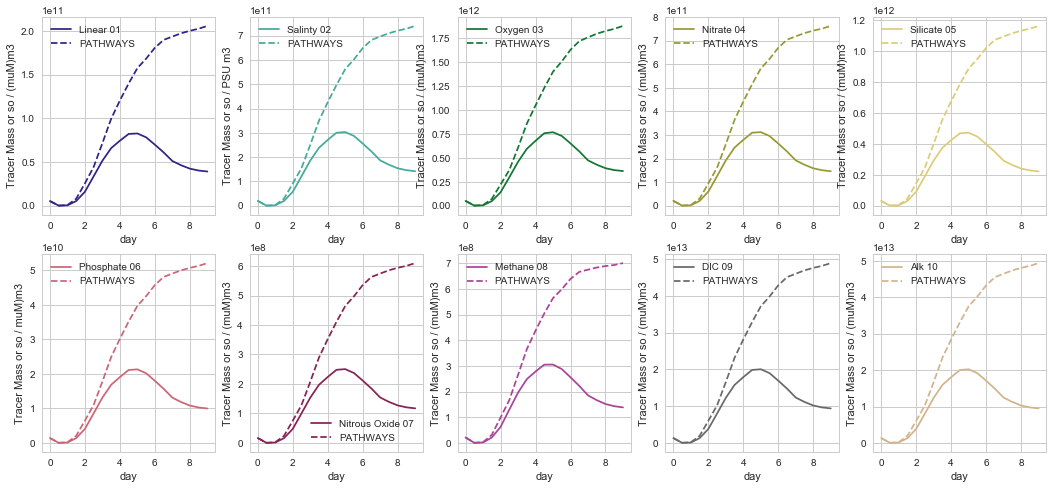

In [43]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')


**Barkley shelf, no canyon**

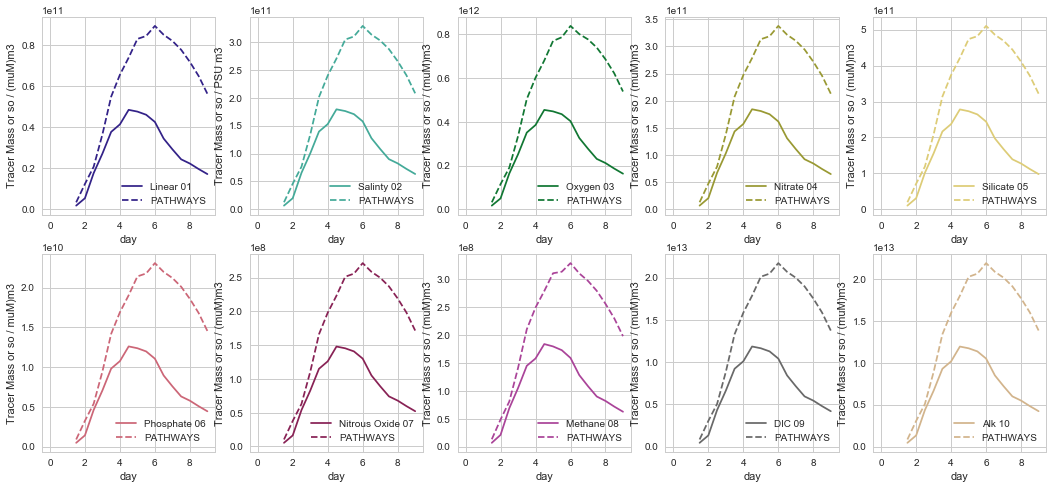

In [44]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')


**Canyon effect** (Can - no Can)

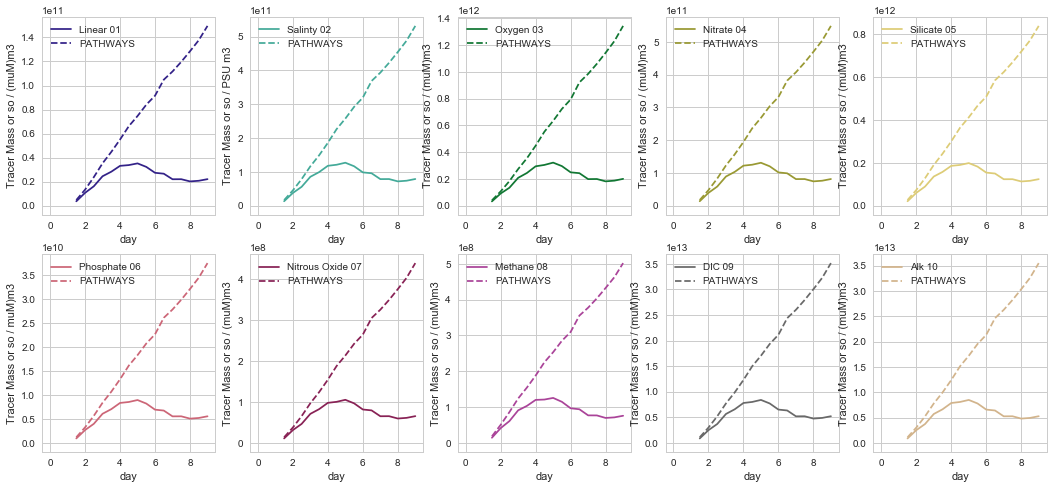

In [45]:
fig, ((ax0,ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8,ax9)) = plt.subplots(2,5,figsize=(18,8))

units = ['(muM)m3','PSU m3','(muM)m3','(muM)m3','(muM)m3','muM)m3','(muM)m3',
         '(muM)m3','(muM)m3','(muM)m3']

axes = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for key, col, lab, unit,ax in zip(tracers, colours, labels, units, axes):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW']
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW']
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW']
    
    else:
        TrMass_Ast = df_Ast['TrMassHCW']
        TrMass_Argo = df_Argo['TrMassHCW']
        TrMass_AstNoC = df_AstNoC['TrMassHCW']
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW']
    
    ax.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color=col, label=lab)
    ax.plot(np.arange(19)/2, TrMass_Argo-TrMass_ArgoNoC,'--', color=col, label='PATHWAYS')
    ax.legend()
    ax.set_ylabel(r'Tracer Mass or so / %s' %unit)
    ax.set_xlabel('day')



#### 4.1 Tracer flux vs upwelling flux $\times$ C_sb (all from model output)

Linear 01, error -20.985 percent 
Linear 01 PATH., error -21.121 percent 
Salinty 02, error -0.231 percent 
Salinty 02 PATH., error 0.109 percent 
Oxygen 03, error 23.171 percent 
Oxygen 03 PATH., error 17.736 percent 
Nitrate 04, error -6.556 percent 
Nitrate 04 PATH., error -5.217 percent 
Silicate 05, error -9.465 percent 
Silicate 05 PATH., error -9.012 percent 
Phosphate 06, error -5.918 percent 
Phosphate 06 PATH., error -4.697 percent 
Nitrous Oxide 07, error -1.361 percent 
Nitrous Oxide 07 PATH., error -0.284 percent 
Methane 08, error -49.745 percent 
Methane 08 PATH., error -36.484 percent 
DIC 09, error 1.002 percent 
DIC 09 PATH., error 1.573 percent 
Alk 10, error 1.752 percent 
Alk 10 PATH., error 2.045 percent 
-13142.916400943504
19821.613892920614


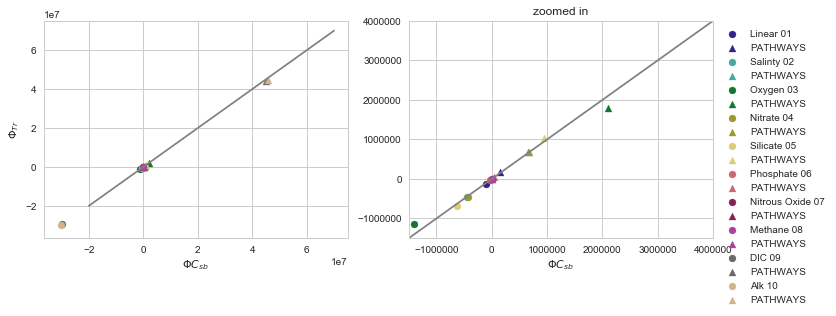

In [46]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,0.7E8, 20)
ax.plot(xx,xx,'-', color='0.5')
ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df = pd.read_csv(filename)
    HCW = df['HCW'][:]
    
    filenameARGO = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    dfARGO = pd.read_csv(filenameARGO)
    HCWARGO = dfARGO['HCW'][:]
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = 1E-3*df['TrMassHCW'][:]
        TrMassARGO = 1E-3*dfARGO['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]
        TrMassARGO = dfARGO['TrMassHCW'][:]
    
    Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(14,18)]))
    Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(14,18)]))
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(14,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(14,18)]))
    
    PhiARGO = np.mean(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    Phi_stdARGO = np.std(np.array([(HCWARGO[ii]-HCWARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    PhiTrARGO = np.mean(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    PhiTr_stdARGO = np.std(np.array([(TrMassARGO[ii]-TrMassARGO[ii-1])/(time[ii]-time[ii-1]) for ii in range(10,18)]))
    
    error = 100*((Phi*C)-PhiTr)/PhiTr
    errorARGO = 100*((PhiARGO*C)-PhiTrARGO)/PhiTrARGO
    
    ax.scatter(Phi*C, PhiTr, c=col, label=lab)
    ax2.scatter(Phi*C, PhiTr, c=col, label=lab)
     
    ax.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label=lab)
    ax2.scatter(PhiARGO*C, PhiTrARGO,marker='^', c=col, label='PATHWAYS')
    
    print('%s, error %1.3f percent ' %(lab, error))
    print('%s PATH., error %1.3f percent ' %(lab, errorARGO))
ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlabel(r'$\Phi C_{sb}$')
ax2.set_xlim(-0.015E8,0.04E8)
ax2.set_ylim(-0.015E8,0.04E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)
print(PhiARGO)

### 5. Comparison to previous scalings

In [47]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [56]:
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model =  103878.21882047845# m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))

Phi_HA2013 = 1.101e+05 m^3/s, Phi_model=1.039e+05 m^3/s, error 5.94 percent


Linear 01, error 73.057 percent 
Salinty 02, error 82.246 percent 
Oxygen 03, error 85.058 percent 
Nitrate 04, error 81.186 percent 
Silicate 05, error 81.217 percent 
Phosphate 06, error 81.743 percent 
Nitrous Oxide 07, error 93.491 percent 
Methane 08, error 42.693 percent 
DIC 09, error 86.201 percent 
Alk 10, error 86.128 percent 
-13142.916400943504


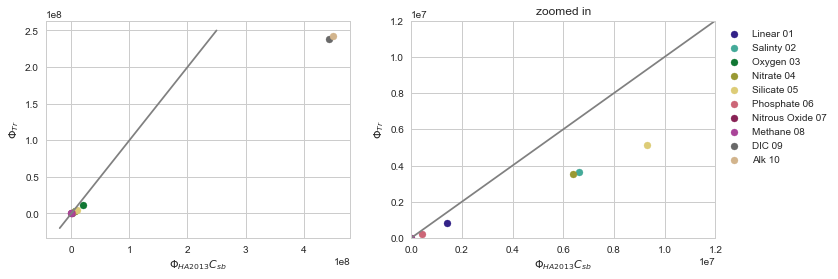

In [49]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(12,4))
xx = np.linspace(-0.2E8,2.5E8, 20)
ax.plot(xx,xx,'-', color='0.5')

ax2.plot(xx,xx,'-', color='0.5')

for key, col, lab, unit, C in zip(tracers, colours, labels, units, sb_conc_A):
    
    filename = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df = pd.read_csv(filename)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass = 1E-3*df['TrMassHCW'][:]
    else:
        TrMass = df['TrMassHCW'][:]
    
    PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
    error = 100*(HA2013*C-PhiTr)/PhiTr
    
    ax.scatter(HA2013*C, PhiTr, c=col, label=lab)
    ax2.scatter(HA2013*C, PhiTr, c=col, label=lab)
     
    
    print('%s, error %1.3f percent ' %(lab, error))

ax.set_ylabel(r'$\Phi_{Tr}$')
ax.set_xlabel(r'$\Phi_{HA2013} C_{sb}$')
ax2.set_ylabel(r'$\Phi_{Tr}$')
ax2.set_xlabel(r'$\Phi_{HA2013} C_{sb}$')
ax2.set_xlim(0,0.12E8)
ax2.set_ylim(0,0.12E8)
   
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title('zoomed in')
print(Phi)

Still pretty ok. Linear has smaller error and methane and nitrous oxide are the worst.

ARGO:

In [50]:
# ARGO RUN
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 0.00880 # Initial at 152.5 m
f = 1.05E-4
U = 0.465
Wiso = 8900
L = 21800

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 174894.4 # m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))

Phi_HA2013 = 1.278e+05 m^3/s, Phi_model=1.749e+05 m^3/s, error -26.93 percent


KV1:

In [51]:
g = 9.81 # accel. gravity
Hs = 150 # Shelf break depth
s = 0.00230 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8900
L = 21800
nz = 104
ny = 360
nx = 616
epsilon = 5    
Hrim = 110
Hh = 100
t = 6.5
R = 4500
#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

#RM&A2019
slope2 = 5.00
param2 = 0.86
intercept2 = -0.012

#RM&A2019
kv_dir = '/ocean/kramosmu/Building_canyon/BuildCanyon/Stratification/paper2/'
ini_kv_file = (kv_dir + 'KrDiff_Ast_e05_kv1E2_104zlev_616x360_Quad.bin')

dt = np.dtype('>f8')  # float 64 big endian
st = [220, 190] # y, x indices of UwH station

dd = 1
ini_kv_profiles = np.zeros(nz)
data = np.fromfile(ini_kv_file, dt)
ini_kv = np.reshape(data,(nz,ny,nx),order='C')
KK = ini_kv[:, st[0], st[1]] 
Zdif = (((KK[int(Hrim/5)+1]-KK[int(Hrim/5)-1]))*t*3600*24)**0.5
dk =  KK[int(Hrim/5)+1]-KK[int(Hrim/5)-1]
Kz =  KK[int(Hrim/5)-4]
Kz_be =  KK[int(Hrim/5)+4]

Dz = abs(ZA[int(Hrim/5)+1]-ZA[int(Hrim/5)-1])
Z = ((f*U*F(Ro(U,f,R))*L)**(0.5))/N

Sdif_min = np.exp(-0.15*Zdif/Dz)
Sdif_max = (Zdif/Dz)*np.exp(-(Kz*t*3600*24)/((epsilon)**2))
S_max = (Z/Hh)*np.exp(-Kz*t*3600*24/Z**2)
S_min = (Z/Hh)*np.exp(-Kz_be*t*3600*24/Z**2)

c_be_0 = 2.72 
c_be_1 = 2.19
c_be_2 =-1.13

c_ab_0 = 7.35
c_ab_1 = 0.21
c_ab_2 = 0.82

Nbe_scaled =  np.sqrt(c_be_0*S_min +c_be_1*Sdif_min +c_be_2)*N
Nab_scaled =  np.sqrt(c_ab_0*S_max + c_ab_1*Sdif_max + c_ab_2)*N
     
if  (c_be_0*S_min +c_be_1*Sdif_min +c_be_2)< 0 :
    N_eff_scaled = (0.75*Nab_scaled)
else:
    N_eff_scaled = (0.75*Nab_scaled + Nbe_scaled) 
    
# From cell in 3.1
Phi_model =  143154.86910830787# m^3/s

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))
RA2019 = ((slope2*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param2*Se)**3))+intercept2)*(U*Wiso*Dh(f,L,N_eff_scaled))
 
print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))
print('Phi_RA2019 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(RA2019, Phi_model, 100*(RA2019-Phi_model)/Phi_model))

Phi_HA2013 = 1.101e+05 m^3/s, Phi_model=1.432e+05 m^3/s, error -23.13 percent
Phi_RA2019 = 6.329e+04 m^3/s, Phi_model=1.432e+05 m^3/s, error -55.79 percent


**Barkley Runs**

In [58]:
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 5.5E-3
f = 1.0E-4
U = 0.3
Wiso = 8300.0
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = -13142.916400943504


Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))


Phi_HA2013 = 2.668e+04 m^3/s, Phi_model=-1.314e+04 m^3/s, error -302.98 percent


Wow, look at that error! No surprise since HCW decreases after day 5 in Barkley run.

PATHWAYS:

In [53]:
# Pahways
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 0.00399#0.00469   #0.00399
f = 1.08E-4
U = 0.495
Wiso = 8300.0
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

# From cell in 3.1
Phi_model = 158138.55 # m^3/s 143154.86910830787

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s, Phi_model=%1.3e m^3/s, error %1.2f percent' %(HA2013, Phi_model, 100*(HA2013-Phi_model)/Phi_model))


Phi_HA2013 = 9.809e+04 m^3/s, Phi_model=1.581e+05 m^3/s, error -37.97 percent


For Barkley runs, the error goes down if I consider a shorter time while HCW is increasing -- days 4-6 for PATHWAYS (17%) and 4-5 for BARKLEY (26%))

### Table

In [54]:
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s','(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']


print ("\t".join(['Run and Tracer &', 
                  '$\Phi_{Tr}$/10^{6} &',
                  '$M_can$/10^{12} &' ,
                  '$M_{can}-M_{nc}/M_{can}$ day 9 &'
                  '$\mathcal{M}$/10^{12} &',
                  '$\mathcal{M}-\mathcal{M}_{nc}/($\mathcal{M}_{nc}-\mathcal{M}_{nc}(0))$',
                 ]))

exp_files = ['saved_calcs/pool_AST.nc',
             'saved_calcs/pool_ARGO.nc',
             'saved_calcs/pool_BAR.nc',
             'saved_calcs/pool_PATH.nc']

exp_files_BAC = ['saved_calcs/BAC_AST.nc',
                 'saved_calcs/BAC_ARGO.nc',
                 'saved_calcs/BAC_BAR.nc',
                 'saved_calcs/BAC_PATH.nc']

  
for key, tr_lab in zip(tracers,labels_tra):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_PathNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    df_Bar = pd.read_csv(f_Bar)
    df_Path = pd.read_csv(f_Path)
    df_BarNoC = pd.read_csv(f_BarNoC)
    df_PathNoC = pd.read_csv(f_PathNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW'][:]/1E-3 # nMm^3 to muMm^3 and muMm^3 to mumol
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW'][:]/1E-3
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW'][:]/1E-3
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW'][:]/1E-3

        TotMass_Ast = 1E-3*df_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = 1E-3*df_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = 1E-3*df_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = 1E-3*df_ArgoNoC['TotTrMass'][:]/1E-3

        TrMass_Bar = 1E-3*df_Bar['TrMassHCW'][:]/1E-3
        TrMass_Path = 1E-3*df_Path['TrMassHCW'][:]/1E-3
        TrMass_BarNoC = 1E-3*df_BarNoC['TrMassHCW'][:]/1E-3
        TrMass_PathNoC = 1E-3*df_PathNoC['TrMassHCW'][:]/1E-3

        TotMass_Bar = 1E-3*df_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = 1E-3*df_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = 1E-3*df_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = 1E-3*df_PathNoC['TotTrMass'][:]/1E-3

    
    else:
        TrMass_Ast = df_Ast['TrMassHCW'][:]/1E-3
        TrMass_Argo = df_Argo['TrMassHCW'][:]/1E-3
        TrMass_AstNoC = df_AstNoC['TrMassHCW'][:]/1E-3
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW'][:]/1E-3

        TotMass_Ast = df_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = df_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = df_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = df_ArgoNoC['TotTrMass'][:]/1E-3

        TrMass_Bar = df_Bar['TrMassHCW'][:]/1E-3
        TrMass_Path = df_Path['TrMassHCW'][:]/1E-3
        TrMass_BarNoC = df_BarNoC['TrMassHCW'][:]/1E-3
        TrMass_PathNoC = df_PathNoC['TrMassHCW'][:]/1E-3

        TotMass_Bar = df_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = df_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = df_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = df_PathNoC['TotTrMass'][:]/1E-3
    
    PhiTr_Ast = np.mean(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Ast_std = np.std(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo = np.mean(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo_std = np.std(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar = np.mean(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar_std = np.std(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path = np.mean(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path_std = np.std(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Ast/1E6, PhiTr_Ast_std/1E6),
                      '%1.2f &' %(TrMass_Ast[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Ast[18]-TrMass_AstNoC[18])/TrMass_Ast[18]),
                      '%1.2f &' %((TotMass_Ast[18]-TotMass_AstNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Ast[18]-TotMass_AstNoC[18])/(TotMass_AstNoC[18]-TotMass_AstNoC[0])),
                     ]))
    print ("\t".join(['Ast. ARGO %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Argo/1E6, PhiTr_Argo_std/1E6),
                      '%1.2f &' %(TrMass_Argo[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Argo[18]-TrMass_ArgoNoC[18])/TrMass_Argo[18]),
                      '%1.2f & ' %((TotMass_Argo[18]-TotMass_ArgoNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Argo[18]-TotMass_ArgoNoC[18])/(TotMass_ArgoNoC[18]-TotMass_ArgoNoC[0])),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Bar/1E6, PhiTr_Bar_std/1E6),
                      '%1.2f &' %(TrMass_Bar[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Bar[18]-TrMass_BarNoC[18])/TrMass_Bar[18]),
                      '%1.2f & ' %((TotMass_Bar[18]-TotMass_BarNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Bar[18]-TotMass_BarNoC[18])/(TotMass_BarNoC[18]-TotMass_BarNoC[0])),
                     ]))
    print ("\t".join(['Bar. Path. %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Path/1E6,PhiTr_Path_std/1E6),
                      '%1.2f &' %(TrMass_Path[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Path[18]-TrMass_PathNoC[18])/TrMass_Path[18]),
                      '%1.2f & ' %((TotMass_Path[18]-TotMass_PathNoC[18])/1E12),
                      '%1.2f skl ' %(100*(TotMass_Path[18]-TotMass_PathNoC[18])/(TotMass_PathNoC[18]-TotMass_PathNoC[0])),
                     ]))
   

Run and Tracer &	$\Phi_{Tr}$/10^{6} &	$M_can$/10^{12} &	$M_{can}-M_{nc}/M_{can}$ day 9 &$\mathcal{M}$/10^{12} &	$\mathcal{M}-\mathcal{M}_{nc}/($\mathcal{M}_{nc}-\mathcal{M}_{nc}(0))$
Astoria Lin &	814.88$\pm$127.08 &	611.07 &	99.38 &	212.65 &	145.51 skl 
Ast. ARGO Lin &	493.39$\pm$93.71 &	367.43 &	-42.44 &	-104.52 & 	-29.13 skl 
Barkley Lin &	-59.39$\pm$141.97 &	39.16 &	56.27 &	16.04 & 	9.80 skl 
Bar. Path. Lin &	238.58$\pm$157.01 &	205.89 &	72.68 &	31.98 & 	17.55 skl 
Astoria Sal &	3633.74$\pm$508.47 &	2626.40 &	99.33 &	19.77 &	64.96 skl 
Ast. ARGO Sal &	2224.57$\pm$422.54 &	1611.29 &	86.70 &	9.77 & 	31.57 skl 
Barkley Sal &	-213.87$\pm$533.20 &	142.02 &	55.44 &	0.99 & 	4.86 skl 
Bar. Path. Sal &	876.23$\pm$574.04 &	739.97 &	71.90 &	1.49 & 	6.69 skl 
Astoria Oxy &	11219.86$\pm$1432.25 &	7854.01 &	99.30 &	-2564.56 &	96.16 skl 
Ast. ARGO Oxy &	6845.62$\pm$1284.41 &	4834.42 &	86.48 &	-1298.71 & 	47.95 skl 
Barkley Oxy &	-513.92$\pm$1384.88 &	362.55 &	55.13 &	-161.16 & 	6.84 skl 
Bar. Pat